In [1]:
from pathlib import Path

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dm_control.rl.control import PhysicsError
from tqdm import tqdm, trange

from flygym import Camera, Fly, SingleFlySimulation
from flygym.arena import GappedTerrain
from flygym.examples import PreprogrammedSteps
from flygym.examples.cpg_controller import CPGNetwork

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
########### SCRIPT PARAMS ############
ENVIRONEMENT_SEED = 0

########### SIM PARAMS ############
Z_SPAWN_POS = 0.5
timestep = 1e-4
run_time = 1.0

########### CPG PARAMS ############
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20

########### HYBRID PARAMS ############
correction_vectors = {
    # unit: radian
    "F": np.array([-0.03, 0, 0, -0.03, 0, 0.03, 0.03]),
    "M": np.array([-0.015, 0.001, 0.025, -0.02, 0, -0.02, 0.0]),
    "H": np.array([0, 0, 0, -0.02, 0, 0.01, -0.02]),
}

right_leg_inversion = [1, -1, -1, 1, -1, 1, 1]
stumbling_force_threshold = -1
correction_rates = {"retraction": (800, 700), "stumbling": (2200, 2100)}
max_increment = 80
retraction_persistance = 20
persistance_init_thr = 20


########### FUNCTIONS ############
def run_simulation(sim, cpg_network, preprogrammed_steps, run_time):
    retraction_correction = np.zeros(6)
    stumbling_correction = np.zeros(6)

    detected_segments = ["Tibia", "Tarsus1", "Tarsus2"]
    stumbling_sensors = {leg: [] for leg in preprogrammed_steps.legs}
    for i, sensor_name in enumerate(sim.fly.contact_sensor_placements):
        leg = sensor_name.split("/")[1][:2]  # sensor_name: eg. "Animat/LFTarsus1"
        segment = sensor_name.split("/")[1][2:]
        if segment in detected_segments:
            stumbling_sensors[leg].append(i)
    stumbling_sensors = {k: np.array(v) for k, v in stumbling_sensors.items()}

    obs, info = sim.reset()

    target_num_steps = int(run_time / sim.timestep)
    obs_list = []

    retraction_perisitance_counter = np.zeros(6)
    retraction_persistance_counter_hist = np.zeros((6, target_num_steps))
    physics_error = False

    for k in trange(target_num_steps):
        # retraction rule: does a leg need to be retracted from a hole?
        end_effector_z_pos = obs["fly"][0][2] - obs["end_effectors"][:, 2]
        end_effector_z_pos_sorted_idx = np.argsort(end_effector_z_pos)
        end_effector_z_pos_sorted = end_effector_z_pos[end_effector_z_pos_sorted_idx]
        if end_effector_z_pos_sorted[-1] > end_effector_z_pos_sorted[-3] + 0.06:
            leg_to_correct_retraction = end_effector_z_pos_sorted_idx[-1]
            if retraction_correction[leg_to_correct_retraction] > persistance_init_thr:
                retraction_perisitance_counter[leg_to_correct_retraction] = 1
        else:
            leg_to_correct_retraction = None

        # update persistance counter
        retraction_perisitance_counter[retraction_perisitance_counter > 0] += 1
        retraction_perisitance_counter[
            retraction_perisitance_counter > retraction_persistance
        ] = 0
        retraction_persistance_counter_hist[:, k] = retraction_perisitance_counter

        cpg_network.step()
        joints_angles = []
        adhesion_onoff = []

        for i, leg in enumerate(preprogrammed_steps.legs):
            # update amount of retraction correction
            if (
                i == leg_to_correct_retraction or retraction_perisitance_counter[i] > 0
            ):  # lift leg
                increment = correction_rates["retraction"][0] * sim.timestep
                retraction_correction[i] += increment
                sim.fly.change_segment_color(sim.physics, f"{leg}Tibia", (1, 0, 0, 1))
            else:  # condition no longer met, lower leg
                decrement = correction_rates["retraction"][1] * sim.timestep
                retraction_correction[i] = max(0, retraction_correction[i] - decrement)
                sim.fly.change_segment_color(
                    sim.physics, f"{leg}Tibia", (0.5, 0.5, 0.5, 1)
                )

            # update amount of stumbling correction
            contact_forces = obs["contact_forces"][stumbling_sensors[leg], :]
            fly_orientation = obs["fly_orientation"]
            # force projection should be negative if against fly orientation
            force_proj = np.dot(contact_forces, fly_orientation)
            if (force_proj < stumbling_force_threshold).any():
                increment = correction_rates["stumbling"][0] * sim.timestep
                stumbling_correction[i] += increment
                sim.fly.change_segment_color(sim.physics, f"{leg}Femur", (1, 0, 0, 1))
            else:
                decrement = correction_rates["stumbling"][1] * sim.timestep
                stumbling_correction[i] = max(0, stumbling_correction[i] - decrement)
                sim.fly.change_segment_color(
                    sim.physics, f"{leg}Femur", (0.5, 0.5, 0.5, 1)
                )

            # retraction correction is prioritized
            if retraction_correction[i] > 0:
                net_correction = retraction_correction[i]
                stumbling_correction[i] = 0
            else:
                net_correction = stumbling_correction[i]

            # get target angles from CPGs and apply correction
            my_joints_angles = preprogrammed_steps.get_joint_angles(
                leg, cpg_network.curr_phases[i], cpg_network.curr_magnitudes[i]
            )
            net_correction = np.clip(net_correction, 0, max_increment)
            if leg[0] == "R":
                net_correction *= right_leg_inversion[i]

            my_joints_angles += net_correction * correction_vectors[leg[1]]
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
                leg, cpg_network.curr_phases[i]
            )
            # No adhesion in stumbling or retracted
            my_adhesion_onoff *= np.logical_not(
                (force_proj < stumbling_force_threshold).any()
                or i == leg_to_correct_retraction
            )
            adhesion_onoff.append(my_adhesion_onoff)

        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        try:
            obs, reward, terminated, truncated, info = sim.step(action)
            obs["retraction_correction"] = retraction_correction.copy()
            obs["stumbling_correction"] = stumbling_correction.copy()
            obs["phase"] = cpg_network.curr_phases.copy()
            obs["magnitude"] = cpg_network.curr_magnitudes.copy()
            obs_list.append(obs)
            sim.render()
        except PhysicsError:
            physics_error = True
            break

    return obs_list, physics_error

In [4]:
np.random.seed(ENVIRONEMENT_SEED)
n_exp = 20
max_x = 4.0
shift_x = 2.0
max_y = 4.0
shift_y = 2.0

positions = np.zeros((n_exp, 3))
positions[:, :2] = np.random.rand(n_exp, 2) * (max_x, max_y) - (shift_x, shift_y)
positions[:, 2] = Z_SPAWN_POS
internal_seeds = np.arange(n_exp)

pos = positions[-1]
seed = internal_seeds[-1]

preprogrammed_steps = PreprogrammedSteps()

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in preprogrammed_steps.legs
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

# Initialize the simulation
fly = Fly(
    enable_adhesion=True,
    draw_adhesion=True,
    init_pose="stretch",
    control="position",
    spawn_pos=pos,
    contact_sensor_placements=contact_sensor_placements,
)
cam = Camera(
    fly=fly,
    camera_id="Animat/camera_right_top_zoomout",
    play_speed=0.1,
    window_size=(700, 560),
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=timestep,
    arena=GappedTerrain(),
)

cpg_network = CPGNetwork(
    timestep=timestep,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=seed,
)

sim.reset()

obs_list, physics_error = run_simulation(
    sim, cpg_network, preprogrammed_steps, run_time
)

100%|██████████| 10000/10000 [01:04<00:00, 156.08it/s]


In [5]:
phases = np.array([obs["phase"] for obs in obs_list])
magnitudes = np.array([obs["magnitude"] for obs in obs_list])
retraction_corrections = np.array([obs["retraction_correction"] for obs in obs_list])
stumbling_corrections = np.array([obs["stumbling_correction"] for obs in obs_list])

In [6]:
timestep = sim.timestep
labels = legs = preprogrammed_steps.legs
rule_labels = ["Retraction", "Stumbling"]
leg_basey_lookup = {
    "right front": 0,
    "right middle": -1,
    "right hind": -2,
    "left front": -3,
    "left middle": -4,
    "left hind": -5,
}
leg_name_lookup = {
    "RF": "right front",
    "LF": "left front",
    "RM": "right middle",
    "LM": "left middle",
    "RH": "right hind",
    "LH": "left hind",
}
color_lookup = {
    "RF": "C0",
    "RM": "C1",
    "RH": "C2",
    "LF": "C3",
    "LM": "C4",
    "LH": "C5",
}

time = np.arange(0, run_time, timestep)


def plot_frame(current_time=None, video_layout=False):
    if video_layout:
        fig, axs = plt.subplots(2, 2, figsize=(10, 4), tight_layout=True)
    else:
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(5, 6), tight_layout=True)

    # phase plot
    ax = axs.flatten()[0]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        phase_ts = np.mod(phases[:, i], np.pi * 2)
        ax.plot(
            time,
            phase_ts + leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)
        ax.fill_between(
            time,
            leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            leg_basey_lookup[leg_name] * np.pi * 3 + np.pi,
            facecolor="gray",
            edgecolor="none",
            alpha=0.2,
            zorder=-1,
            linewidth=1,
        )
    if video_layout:
        ax.set_xlabel("Time (s)")
    ax.set_yticks(np.array(list(leg_basey_lookup.values())) * np.pi * 3)
    ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Phase (wrapped, rad)")

    # amplitude plot
    ax = axs.flatten()[1]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        mag_ts = magnitudes[:, i]
        ax.plot(
            time,
            mag_ts + leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)
        ax.axhline(
            leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color="k",
            linestyle="-",
            linewidth=0.5,
            zorder=-1,
        )
    if video_layout:
        ax.set_yticks([])
        ax.set_yticklabels([])
    else:
        ax.set_yticks(np.array(list(leg_basey_lookup.values())) * 1.5)
        ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Amplitude (AU)")
    if video_layout:
        ax.set_xlabel("Time (s)")

    # rule plot
    ax = axs.flatten()[2]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        retraction_ts = retraction_corrections[:, i]
        stumbling_ts = stumbling_corrections[:, i]
        ax.plot(
            time,
            retraction_ts + leg_basey_lookup[leg_name] * 34 - 17,
            linestyle="-",
            color=color_lookup[leg_code],
            linewidth=1,
        )
        ax.plot(
            time,
            stumbling_ts + leg_basey_lookup[leg_name] * 34 - 17,
            linestyle="--",
            color=color_lookup[leg_code],
            linewidth=1,
        )
        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)
        ax.axhline(
            leg_basey_lookup[leg_name] * 34 - 17,
            color="k",
            linestyle="-",
            linewidth=0.5,
            zorder=-1,
        )
    ax.set_yticks(np.array(list(leg_basey_lookup.values())) * 34 - 10)
    ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    if video_layout:
        ax.set_ylabel("Feedback-based\nadjustment (AU)")
    else:
        ax.set_ylabel("Feedback-based adjustment (AU)")
    ax.set_xlabel("Time (s)")

    if video_layout:
        axs.flatten()[3].axis("off")

    sns.despine()
    return fig

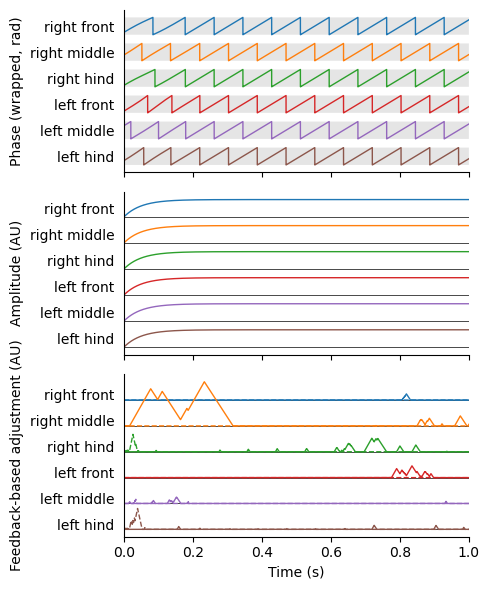

In [7]:
plt.style.use("default")
fig = plot_frame()
fig.savefig("outputs/hybrid.pdf", transparent=True)

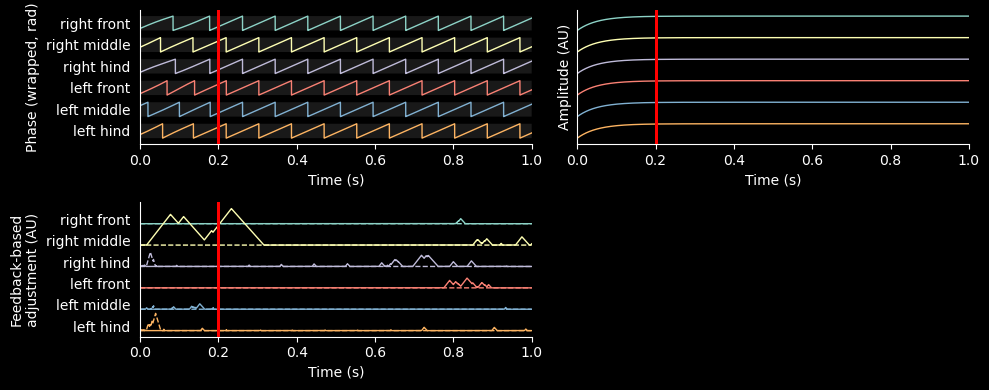

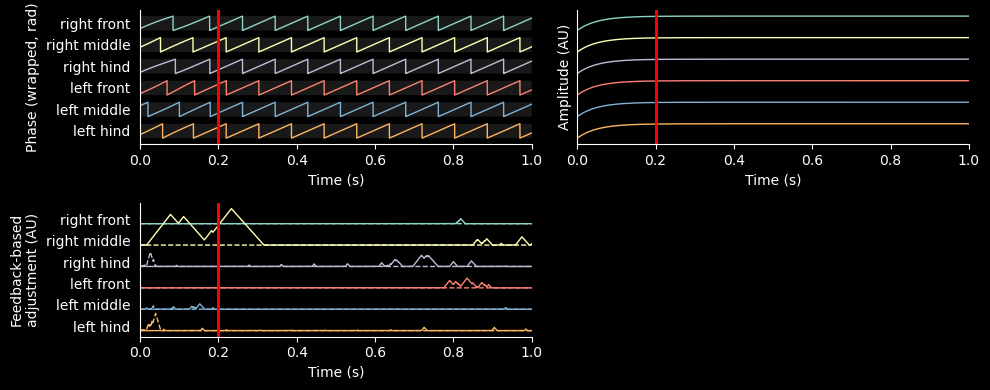

In [8]:
plt.style.use("dark_background")
plot_frame(current_time=0.2, video_layout=True)

In [9]:
def matplotlib_figure_to_array(fig):
    fig.canvas.draw()
    return np.array(fig.canvas.buffer_rgba())[..., :3]


def merge_frame_and_time_series(i, frame):
    current_time = i * cam._eff_render_interval
    time_series_fig = plot_frame(current_time, video_layout=True)
    time_series_img = matplotlib_figure_to_array(time_series_fig)
    plt.close(fig=time_series_fig)
    assert frame.shape[0] >= time_series_img.shape[0]
    width = frame.shape[1]
    ts_height = int(width * time_series_img.shape[0] / time_series_img.shape[1])
    time_series_img = cv2.resize(time_series_img, (width, ts_height))
    merged_frame = np.concatenate([frame[:, :, :3], time_series_img[:, :, :3]], axis=0)
    return merged_frame


frames_to_render = cam._frames[: int(1 / cam._eff_render_interval)]
video_shape = merge_frame_and_time_series(0, frames_to_render[0]).shape

with imageio.get_writer("outputs/hybrid.mp4", fps=cam.fps) as writer:
    for i, frame in tqdm(enumerate(frames_to_render), total=len(frames_to_render)):
        merged_frame = merge_frame_and_time_series(i, frame)
        writer.append_data(merged_frame)

100%|██████████| 300/300 [00:30<00:00,  9.90it/s]
